# **Analyzing and Predicting Structural Damage Post-Earthquake in Kavrepalanchok, Nepal**
---

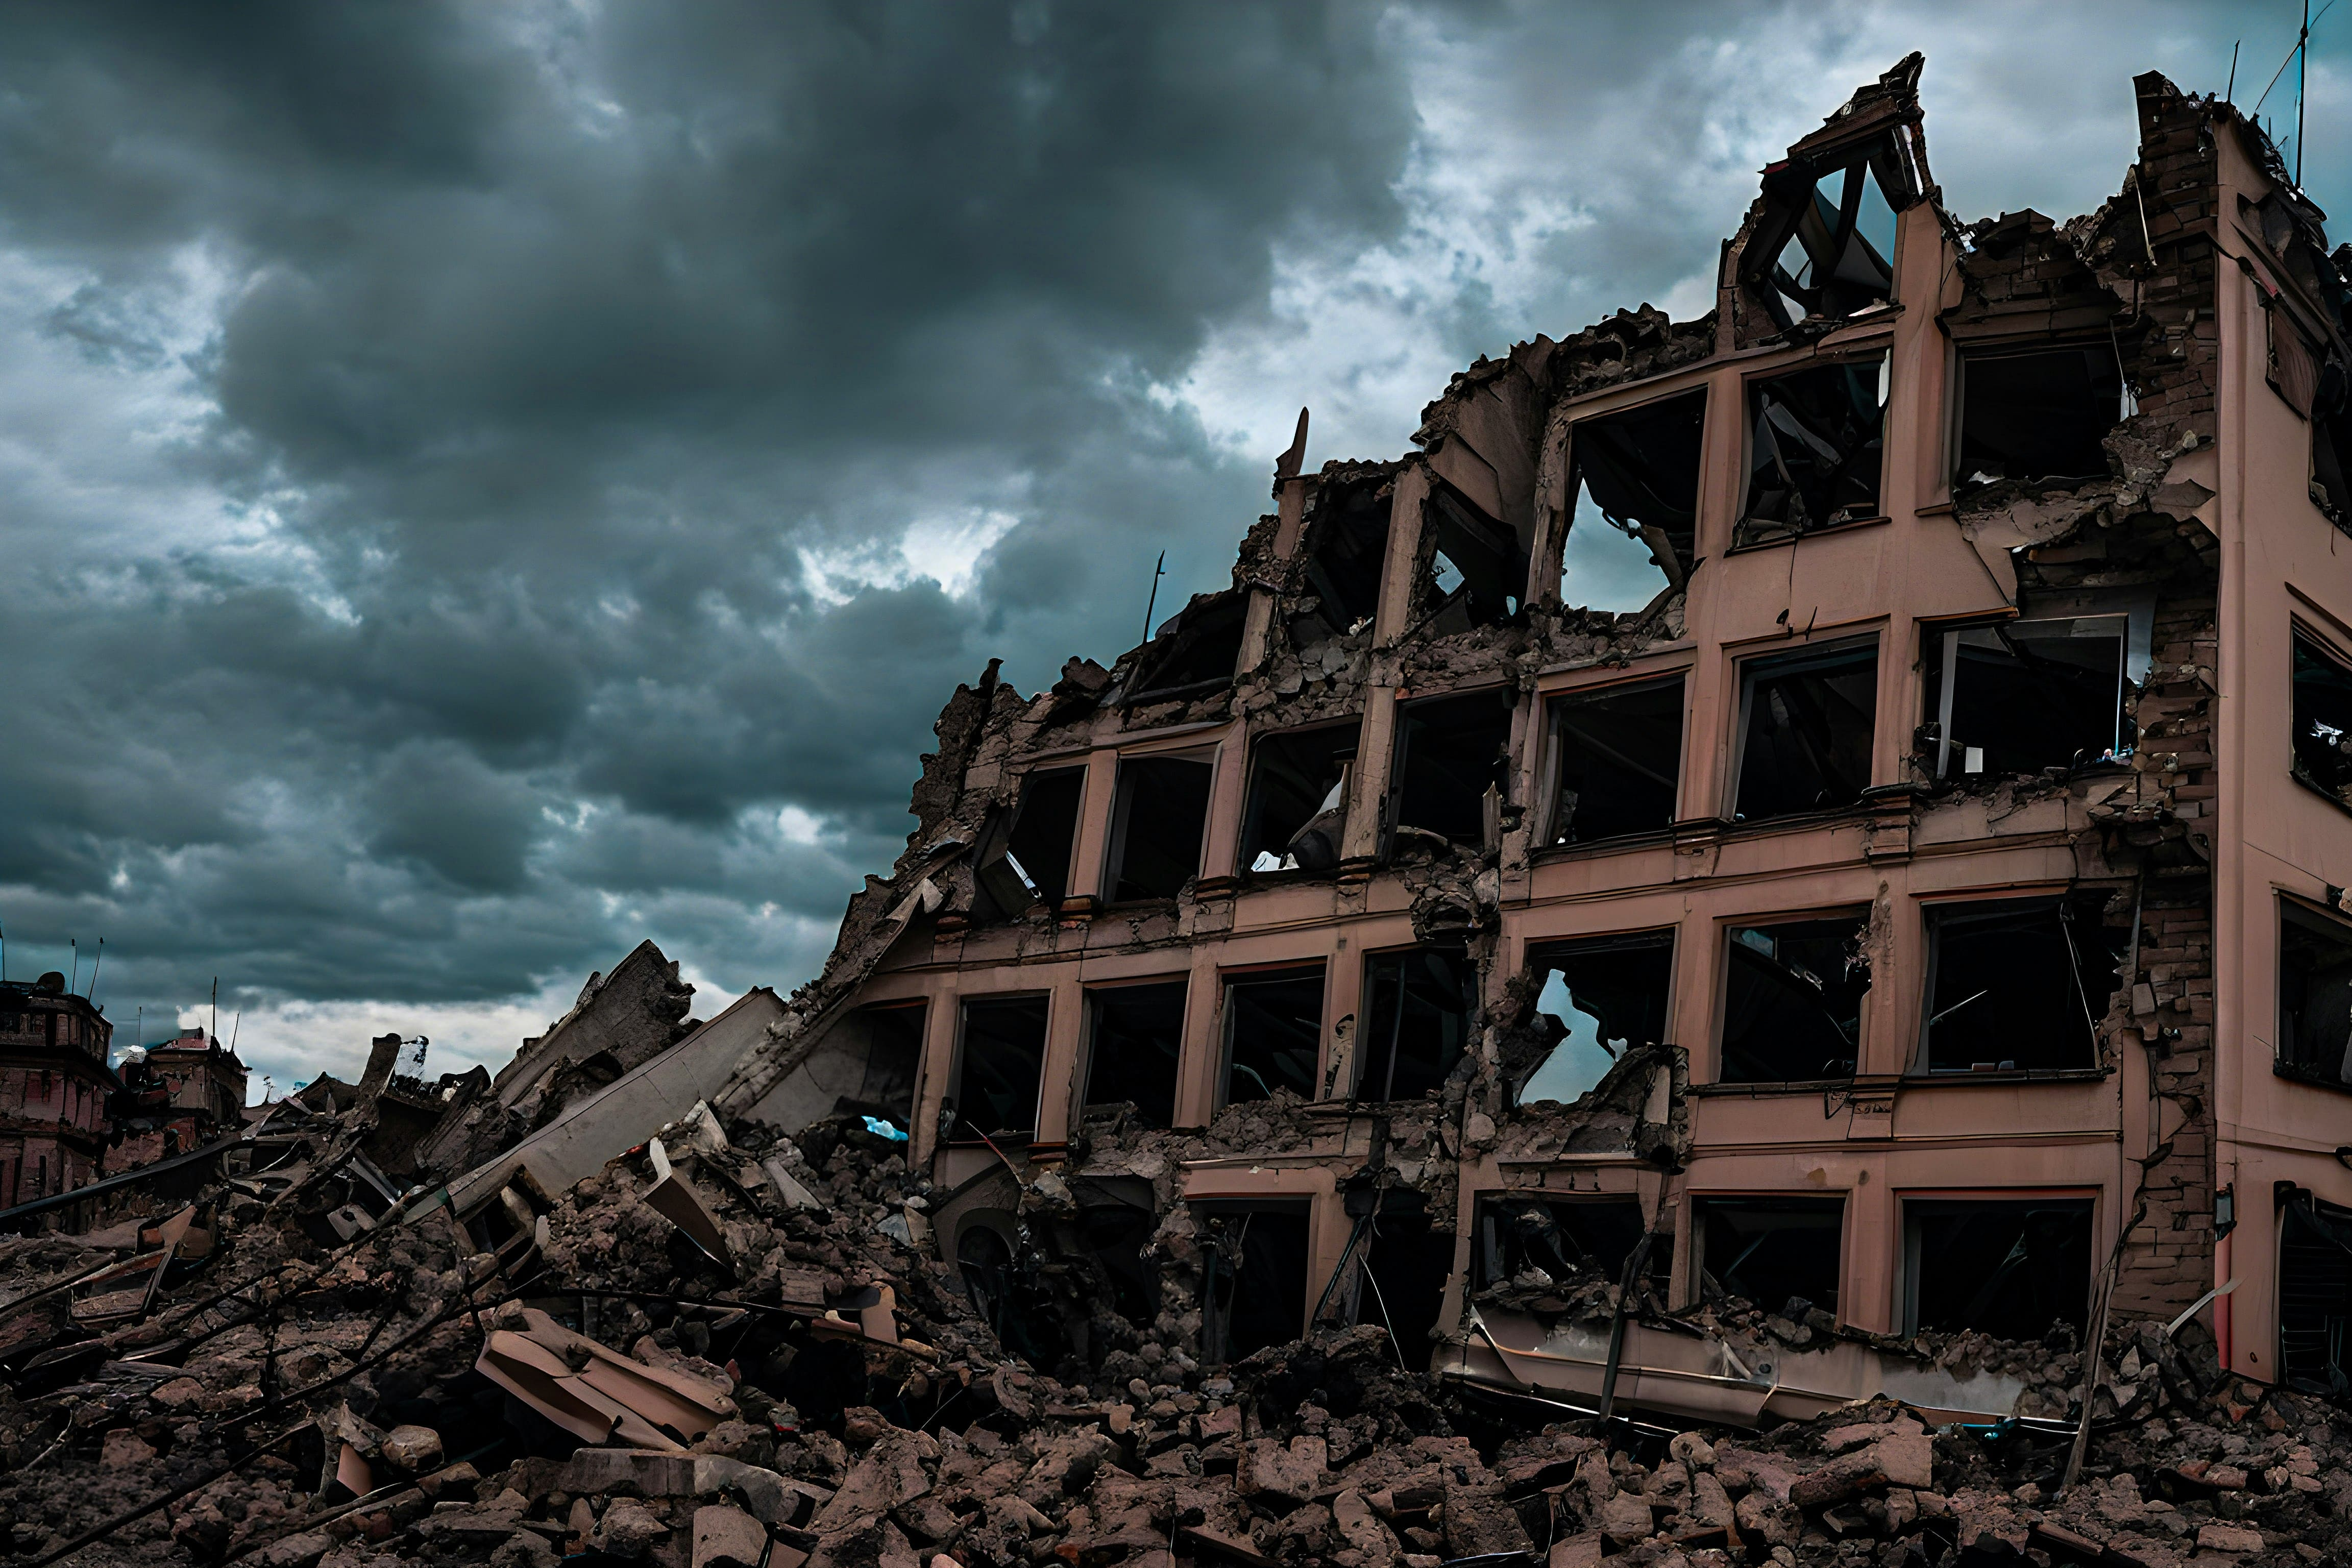

This project addresses the critical challenge of predicting building damage from earthquakes, drawing lessons from the devastating 2015 Nepal earthquake. Focusing on the heavily impacted Kavrepalanchok district, the initiative involved meticulously collecting and organizing detailed building characteristics such as age, height, foundation, and roof types into a robust SQLite database. The core objective was to develop a predictive model capable of identifying buildings likely to suffer severe damage *before* an earthquake, thereby enabling proactive reinforcement and targeted aid distribution to enhance community resilience.

A significant hurdle encountered was the imbalanced nature of the dataset, where severely damaged buildings vastly outnumbered non-severely damaged ones, leading to initial model bias. To overcome this, two key strategies were employed: SMOTE (Synthetic Minority Oversampling Technique) was used to generate synthetic examples of non-severely damaged buildings, while Random Undersampling reduced the number of severely damaged building instances. By carefully tuning a Random Forest classifier and applying these balancing techniques, the project successfully developed a predictive tool that offers improved accuracy in identifying vulnerable structures, balancing the ability to detect true damage with reliable predictions.

In this project, we will work with data from Open Data Nepal. **You can get the datasets from Kaggle [here](https://www.kaggle.com/datasets/arashnic/earthquake-magnitude-damage-and-impact?select=mapping.csv).**

---

**PS.: This project was carried out using Google Colab**

---


## **Let's Get Started!!**

In [ ]:
!pip install pydantic-settings
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3
from glob import glob
import joblib
import matplotlib.pyplot as plt

import sqlite3
import warnings
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, learning_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

warnings.simplefilter(action="ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
import os

# Define the file path
env_file_path = os.path.join(os.getcwd(), ".env")  # Create in current directory

# iNSERT YOUR NGROK token below (Don't share with anyone)
env_vars = {
    "NGROK_TOKEN": "INSERT YOUR NGROK TOKEN HERE",
    "DB_NAME": "nepal.sqlite",
    "MODEL_DIRECTORY": "models",
}
# Write the variables to the .env file
with open(env_file_path, "w") as f:
    for key, value in env_vars.items():
        f.write(f"{key}={value}\n")

print(f".env file created at: {env_file_path}")

.env file created at: /content/.env


We will build a `configue` module to manage the configuration settings, such as Ngrok token and database locations, using environment variables. This module will contain the `Settings` class that will use Pydantic's BaseSettings to manage manage the configuration settings, loading configuration variables (like ngrok token and database name) from environment variables.

In [ ]:
%%writefile config.py
import os
from pydantic_settings import BaseSettings


def get_db_path(db_name: str = "stocks.sqlite") -> str:
    """Constructs the full path to the SQLite database file."""
    # Get the current working directory
    base_dir = os.getcwd()
    # Join the base directory and database name to create the full path
    db_path = os.path.join(base_dir, db_name)
    return db_path


class Settings(BaseSettings):
    """Uses pydantic to define settings for project."""

    ngrok_token: str
    db_name: str
    model_directory: str

    class Config:
        env_file = ".env"


# Create instance of `Settings` class
settings = Settings()

In [ ]:
from config import settings
print(settings.db_name)

nepal.sqlite


## **Build the SQLite Database**

### **1. Insert 'building_damage_assessment' table**

In [ ]:
# Connect to our nepal.sqlite database
conn = sqlite3.connect(settings.db_name)

In [ ]:
# Load the data into a DataFrame
df_damage = pd.read_csv('/content/drive/MyDrive/My_Portfolio_Projects/Project_Five/Nepal_Earthquake_Data/csv_building_damage_assessment.csv', low_memory=False)
# Load the DataFrame to the SQLite Database
df_damage.to_sql('building_damage_assessment', conn, if_exists='replace', index=False)

762106

In [ ]:
# Get a list of tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Print the table names
print(tables['name'].tolist())

In [ ]:
query= """
SELECT name AS column_name, type AS data_type
FROM PRAGMA_TABLE_INFO('building_damage_assessment');
"""
pd.read_sql_query(query, conn)

,column_name,data_type
0,building_id,REAL
1,district_id,INTEGER
2,vdcmun_id,INTEGER
3,ward_id,INTEGER
4,damage_overall_collapse,TEXT
...,...,...
74,has_geotechnical_risk_liquefaction,INTEGER
75,has_geotechnical_risk_landslide,INTEGER
76,has_geotechnical_risk_rock_fall,INTEGER
77,has_geotechnical_risk_flood,INTEGER


Here are the features with their meanings:

- `building_id`: A unique ID that identifies every individual building in the survey.  
- `district_id`: District where the building is located.  
- `vdcmun_id`: Municipality where the building is located.  
- `ward_id`: Ward (smallest political or administrative unit) where the building is located.
- `damage_overall_collapse`: Overall damage assessment for the building - collapse.  
- `damage_overall_leaning`: Overall damage assessment for the building - leaning.  
- `damage_overall_adjacent_building_risk`: Adjacent building risk.  
- `damage_foundation_severe`: Categorical variable that captures severe foundational damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_foundation_moderate`: Categorical variable that captures moderate foundational damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_foundation_insignificant`: Categorical variable that captures insignificant foundational damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_roof_severe`: Categorical variable that captures severe roof damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_roof_moderate`: Categorical variable that captures moderate roof damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_roof_insignificant`: Categorical variable that captures insignificant roof damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_corner_separation_severe`: Categorical variable that captures severe corner separation damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_corner_separation_moderate`: Categorical variable that captures moderate corner separation damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_corner_separation_insignificant`: Categorical variable that captures insignificant corner separation damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_diagonal_cracking_severe`: Categorical variable that captures severe diagonal cracking damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_diagonal_cracking_moderate`: Categorical variable that captures moderate diagonal cracking damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_diagonal_cracking_insignificant`: Categorical variable that captures insignificant diagonal cracking damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_in_plane_failure_severe`: Categorical variable that captures severe in-plane failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_in_plane_failure_moderate`: Categorical variable that captures moderate in-plane failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_in_plane_failure_insignificant`: Categorical variable that captures insignificant in-plane failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_out_of_plane_failure_severe`: Categorical variable that captures severe out-of-plane failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_out_of_plane_failure_moderate`: Categorical variable that captures moderate out-of-plane failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_out_of_plane_failure_insignificant`: Categorical variable that captures insignificant out-of-plane failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_out_of_plane_failure_walls_ncfr_severe`: Categorical variable that captures severe out-of-plane failure of walls not carrying floor/roof in the building in terms of the proportion of overall area that is severely damaged.  
- `damage_out_of_plane_failure_walls_ncfr_moderate`: Categorical variable that captures moderate out-of-plane failure of walls not carrying floor/roof in the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_out_of_plane_failure_walls_ncfr_insignificant`: Categorical variable that captures insignificant out-of-plane failure of walls not carrying floor/roof in the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_gable_failure_severe`: Categorical variable that captures severe gable failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_gable_failure_moderate`: Categorical variable that captures moderate gable failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_gable_failure_insignificant`: Categorical variable that captures insignificant gable failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_delamination_failure_severe`: Categorical variable that captures delamination failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_delamination_failure_moderate`: Categorical variable that captures moderate delamination failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_delamination_failure_insignificant`: Categorical variable that captures insignificant delamination failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_column_failure_severe`: Categorical variable that captures severe column failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_column_failure_moderate`: Categorical variable that captures moderate column failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_column_failure_insignificant`: Categorical variable that captures insignificant column failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_beam_failure_severe`: Categorical variable that captures severe beam failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_beam_failure_moderate`: Categorical variable that captures moderate beam failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_beam_failure_insignificant`: Categorical variable that captures insignificant beam failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_infill_partition_failure_severe`: Categorical variable that captures severe infill/partition failure related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_infill_partition_failure_moderate`: Categorical variable that captures moderate infill/partition failure related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_infill_partition_failure_insignificant`: Categorical variable that captures insignificant infill/partition failure related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_staircase_severe`: Categorical variable that captures severe staircase related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_staircase_moderate`: Categorical variable that captures moderate staircase related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_staircase_insignificant`: Categorical variable that captures insignificant staircase related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_parapet_severe`: Categorical variable that captures severe parapet related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_parapet_moderate`: Categorical variable that captures moderate parapet related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_parapet_insignificant`: Categorical variable that captures insignificant parapet related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `damage_cladding_glazing_severe`: Categorical variable that captures severe cladding/glazing related damage to the building in terms of the proportion of overall area that is severely damaged.  
- `damage_cladding_glazing_moderate`: Categorical variable that captures moderate cladding/glazing related damage to the building in terms of the proportion of overall area that is moderately damaged.  
- `damage_cladding_glazing_insignificant`: Categorical variable that captures insignificant cladding/glazing related damage to the building in terms of the proportion of overall area that is insignificantly damaged.  
- `area_assesed`: Indicates the nature of the damage assessment in terms of the areas of the building that were assessed.  
- `damage_grade`: Damage grade assigned to the building by the surveyor after assessment.  
- `technical_solution_proposed`: Technical solution proposed by the surveyor after assessment.  
- `has_repair_started`: Flag variable that indicates if the repair work had started during the time of the survey.  
- `has_damage_foundation`: Flag variable that indicates if the building has foundational damage.  
- `has_damage_roof`: Flag variable that indicates if the building has roof damage.  
- `has_damage_corner_separation`: Flag variable that indicates if the building has corner separation related damage.  
- `has_damage_diagonal_cracking`: Flag variable that indicates if the building has diagonal cracking related damage.  
- `has_damage_in_plane_failure`: Flag variable that indicates if the building has in-plane failure.  
- `has_damage_out_of_plane_failure`: Flag variable that indicates if the building has out-of-plane failure.  
- `has_damage_out_of_plane_walls_ncfr_failure`: Flag variable that indicates if the building has out-of-plane failure of walls not carrying floor or roof.  
- `has_damage_gable_failure`: Flag variable that indicates if the building has gable failure.  
- `has_damage_delamination_failure`: Flag variable that indicates if the building has delamination failure.  
- `has_damage_column_failure`: Flag variable that indicates if the building has column failure.  
- `has_damage_beam_failure`: Flag variable that indicates if the building has beam failure.  
- `has_damage_infill_partition_failure`: Flag variable that indicates if the building has infill/partition failure.  
- `has_damage_staircase`: Flag variable that indicates if the building has damaged staircase.  
- `has_damage_parapet`: Flag variable that indicates if the building has damaged parapet.  
- `has_damage_cladding_glazing`: Flag variable that indicates if the building has damaged cladding/glazing.  
- `has_geotechnical_risk`: Flag variable that indicates if the building has geotechnical risk.  
- `has_geotechnical_risk_land_settlement`: Flag variable that indicates if the building has geotechnical risks related to land settlement.  
- `has_geotechnical_risk_fault_crack`: Flag variable that indicates if the building has geotechnical risks related to fault cracking.  
- `has_geotechnical_risk_liquefaction`: Flag variable that indicates if the building has geotechnical risks related to liquefaction.  
- `has_geotechnical_risk_landslide`: Flag variable that indicates if the building has geotechnical risks related to landslide.  
- `has_geotechnical_risk_rock_fall`: Flag variable that indicates if the building has geotechnical risk related to rockfall.  
- `has_geotechnical_risk_flood`: Flag variable that indicates if the building has geotechnical risks related to flood.  
- `has_geotechnical_risk_other`: Flag variable that indicates if the building has any other geotechnical risk.  

In [ ]:
query = '''
SELECT *
FROM building_damage_assessment
LIMIT 10
'''
pd.read_sql_query(query, conn)

,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,...,has_damage_parapet,has_damage_cladding_glazing,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_liquefaction,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,has_geotechnical_risk_flood,has_geotechnical_risk_other
0,1.201010e+11,12,1207,120703,Moderate-Heavy,Insignificant/light,None,None,Moderate-Heavy-(<1/3),Insignificant/light-(<1/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,1.201010e+11,12,1207,120703,Severe-Extreme,Severe-Extreme,Insignificant/light,Severe-Extreme-(>2/3),None,None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,1.201010e+11,12,1207,120703,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,None,Moderate-Heavy-(>2/3),None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,1.201010e+11,12,1207,120703,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,None,Moderate-Heavy-(>2/3),None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,1.201010e+11,12,1207,120703,Insignificant/light,None,None,None,None,Insignificant/light-(<1/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,1.201010e+11,12,1207,120703,Insignificant/light,Insignificant/light,None,None,None,Insignificant/light-(1/3-2/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
6,1.201010e+11,12,1207,120703,None,None,None,None,None,None,...,NaN,NaN,0.0,0,0,0,0,0,0,0
7,1.201010e+11,12,1207,120703,None,None,None,None,None,None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
8,1.201010e+11,12,1207,120703,Moderate-Heavy,Insignificant/light,None,None,None,Insignificant/light-(<1/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
9,1.201010e+11,12,1207,120703,Moderate-Heavy,None,None,None,None,Insignificant/light-(<1/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [ ]:
query = '''
SELECT COUNT(*) AS num_rows
FROM building_damage_assessment
'''
pd.read_sql_query(query, conn)

,num_rows
0,762106


In [ ]:
# Get the number of unique buildings from the 'building_damage_assessment' table
query= """
SELECT COUNT(DISTINCT(building_id)) AS unique_buildings
FROM building_damage_assessment
"""
pd.read_sql_query(query, conn)

,COUNT(DISTINCT(building_id))
0,762106


In [ ]:
# Get the name of each district_id
query = """
SELECT DISTINCT district_id, district_name
FROM id_name;
"""
pd.read_sql_query(query, conn)

,district_id,district_name
0,12,Okhaldhunga
1,20,Sindhuli
2,21,Ramechhap
3,22,Dolakha
4,23,Sindhupalchok
5,24,Kavrepalanchok
6,28,Nuwakot
7,29,Rasuwa
8,30,Dhading
9,31,Makwanpur


In [ ]:
# Get the number of unique building in each district from the building_damage_assessment
query = '''
SELECT district_id, (COUNT(DISTINCT(building_id))) AS unique_buildings_count
FROM building_damage_assessment
GROUP BY district_id
ORDER BY unique_buildings_count DESC;
'''
pd.read_sql_query(query, conn)

,district_id,unique_buildings_count
0,24,98019
1,31,90994
2,30,89122
3,23,88741
4,36,78074
5,28,77148
6,20,68750
7,22,60639
8,21,58623
9,12,39352


We can see that district_id 24 (Kavrepalanchok) has the highest number of damaged buildings while district_id 29 (Rasuwa) has the lowest number.

In [ ]:
# Get the number of unique districts from the 'building_damage_assessment' table
query= """
SELECT COUNT(DISTINCT(district_id)) AS unique_districts
FROM building_damage_assessment
"""
pd.read_sql_query(query, conn)

,unique_districts
0,11


In [ ]:
# Get the number of unique municipalities from the 'building_damage_assessment' table
query= """
SELECT COUNT(DISTINCT(vdcmun_id)) AS unique_municipalities
FROM building_damage_assessment
"""
pd.read_sql_query(query, conn)

,unique_municipalities
0,110


In [ ]:
# Get the number of unique wards from the 'building_damage_assessment' table
query= """
SELECT COUNT(DISTINCT(ward_id)) AS unique_wards
FROM building_damage_assessment
"""
pd.read_sql_query(query, conn)

,unique_wards
0,945


### **2. Insert 'id_mapping' table**

In [ ]:
df_id_map = pd.read_csv('/content/drive/MyDrive/My_Portfolio_Projects/Project_Five/Nepal_Earthquake_Data/mapping.csv')
df_id_map.to_sql( 'id_mapping', conn, if_exists='replace', index=False)

In [ ]:
# Get a list of tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Print the table names
print(tables['name'].tolist())

In [ ]:
query= """
SELECT name AS column_name, type AS data_type
FROM PRAGMA_TABLE_INFO('id_mapping');
"""
pd.read_sql_query(query, conn)

,column_name,data_type
0,individual_id,INTEGER
1,household_id,INTEGER
2,building_id,INTEGER


Here's what each column name means:

`building_id`: A unique ID that identifies a unique building from the survey  

`household_id`: A unique ID that identifies every individual household  


In [ ]:
query = '''
SELECT *
FROM id_mapping
LIMIT 10
'''
pd.read_sql_query(query, conn)

,individual_id,household_id,building_id
0,12010200004101001,12010200004101,120102000041
1,12010200004101002,12010200004101,120102000041
2,12010200004101003,12010200004101,120102000041
3,12010200004101004,12010200004101,120102000041
4,12010200004101005,12010200004101,120102000041
5,12010200004101006,12010200004101,120102000041
6,12010200010101001,12010200010101,120102000101
7,12010200010101002,12010200010101,120102000101
8,12010200010101003,12010200010101,120102000101
9,12010200010101004,12010200010101,120102000101


In [ ]:
query = '''
SELECT COUNT(*) AS num_rows
FROM id_mapping
'''
pd.read_sql_query(query, conn)

,num_rows
0,1851740


In [ ]:
# Get the number of unique buildings from the 'id_mapping' table
query= """
SELECT count(distinct(building_id)) AS unique_buildings
FROM id_mapping
"""
pd.read_sql_query(query, conn)


,unique_buildings
0,347949


### **3. Insert 'id_name' table**


In [ ]:
df_id_name = pd.read_csv('/content/drive/MyDrive/My_Portfolio_Projects/Project_Five/Nepal_Earthquake_Data/id_name.csv', low_memory=False)
df_id_name.to_sql( 'id_name', conn, if_exists='replace', index=False)

949

In [ ]:
# Get a list of tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Print the table names
print(tables['name'].tolist())

In [ ]:
query= """
SELECT name AS column_name, type AS data_type
FROM PRAGMA_TABLE_INFO('id_name');
"""
pd.read_sql_query(query, conn)

,column_name,data_type
0,ward_id,INTEGER
1,vdcmun_id,INTEGER
2,vdcmun_name,TEXT
3,district_id,INTEGER
4,district_name,TEXT


Where:

`vdcmun_id`: Municipality of residence of the household
  
`district_id`: District of residence of the household  

In [ ]:
query = '''
SELECT *
FROM id_name
LIMIT 10
'''
pd.read_sql_query(query, conn)

,ward_id,vdcmun_id,vdcmun_name,district_id,district_name
0,120101,1201,Champadevi Rural Municipality,12,Okhaldhunga
1,120102,1201,Champadevi Rural Municipality,12,Okhaldhunga
2,120103,1201,Champadevi Rural Municipality,12,Okhaldhunga
3,120104,1201,Champadevi Rural Municipality,12,Okhaldhunga
4,120105,1201,Champadevi Rural Municipality,12,Okhaldhunga
5,120106,1201,Champadevi Rural Municipality,12,Okhaldhunga
6,120107,1201,Champadevi Rural Municipality,12,Okhaldhunga
7,120108,1201,Champadevi Rural Municipality,12,Okhaldhunga
8,120109,1201,Champadevi Rural Municipality,12,Okhaldhunga
9,120110,1201,Champadevi Rural Municipality,12,Okhaldhunga


In [ ]:
query = '''
SELECT COUNT(*) AS num_rows
FROM id_name
'''
pd.read_sql_query(query, conn)

,num_rows
0,949


### **4. Insert the 'building_structure' table**


In [ ]:
df_structure = pd.read_csv('/content/drive/MyDrive/My_Portfolio_Projects/Project_Five/Nepal_Earthquake_Data/csv_building_structure.csv', low_memory=False)
df_structure.to_sql('building_structure', conn, if_exists='replace', index=False)

In [ ]:
# Get a list of tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Print the table names
print(tables['name'].tolist())

In [ ]:
# Get the column names in the building_structure table
query= """
SELECT name AS column_name, type AS data_type
FROM PRAGMA_TABLE_INFO('building_structure');
"""
pd.read_sql_query(query, conn)

,column_name,data_type
0,building_id,INTEGER
1,district_id,INTEGER
2,vdcmun_id,INTEGER
3,ward_id,INTEGER
4,count_floors_pre_eq,INTEGER
5,count_floors_post_eq,INTEGER
6,age_building,INTEGER
7,plinth_area_sq_ft,INTEGER
8,height_ft_pre_eq,INTEGER
9,height_ft_post_eq,INTEGER


Where:

- **`building_id`**: "A unique ID that identifies a unique building from the survey."  
- **`district_id`**: " District where the building is located."
- **`vdcmun_id`**: "Municipality where the building is located."
- **`ward_id`**: "Ward (smallest political or administrative unit) where the building is located."
- **`count_floors_pre_eq`**: "Number of floors that the building had before the earthquake."  
- **`count_floors_post_eq`**: "Number of floors that the building had after the earthquake."  
- **`age_building`**: "Age of the building (in years)."  
- **`plinth_area_sq_ft`**: "Plinth area of the building (in square feet)."  
- **`height_ft_pre_eq`**: "Height of the building before the earthquake (in feet)."  
- **`height_ft_post_eq`**: "Height of the building after the earthquake (in feet)."  
- **`land_surface_condition`**: "Surface condition of the land in which the building is built."  
- **`foundation_type`**: "Type of foundation used in the building."  
- **`roof_type`**: "Type of roof used in the building. Categories are (1) light bamboo/timber, (2) heavy bamboo timber, and (3) reinforced cement concrete/reinforced brick/reinforced brick concrete."  
- **`ground_floor_type`**: "Ground floor type."  
- **`other_floor_type`**: "Type of construction used in other floors (except ground floor and roof)."  
- **`position`**: "Position of the building."  
- **`plan_configuration`**: "Building plan configuration."  
- **`has_superstructure_adobe_mud`**: "Flag variable that indicates if the building has adobe/mud superstructure."
- **`has_superstructure_mud_mortar_stone`**: "Flag variable that indicates if the building has mud-mortar stone superstructure"
- **`has_superstructure_stone_flag`**: "Flag variable that indicates if the building has stone flag superstructure."  
- **`has_superstructure_cement_mortar_stone`**: "Flag variable that indicates if the building has cement-mortar stone superstructure."
- **`has_superstructure_mud_mortar_brick`**: "Flag variable that indicates if the building has mud-mortar brick superstructure."
- **`has_superstructure_cement_mortar_brick`**: "Flag variable that indicates if the building has cement-mortar brick superstructure."
- **`has_superstructure_timber`**: "Flag variable that indicates if the building has timber superstructure."
- **`has_superstructure_bamboo`**: "Flag variable that indicates if the building has bamboo superstructure."
- **`has_superstructure_rc_non_engineered`**: "Flag variable that indicates if the building has non-engineered reinforced concrete superstructure."
- **`has_superstructure_rc_engineered`**: "Flag variable that indicates if the building has engineered reinforced concrete superstructure."
- **`has_superstructure_other`**: "Flag variable that indicates if the building has other superstructure types."
- **`condition_post_eq`**: "Actual condition of the building after the earthquake."  
- **`damage_grade`**: "Damage grade assigned to the building by the surveyor after assessment."  
- **`technical_solution_proposed`**: "Technical solution proposed by the surveyor after assessment."


In [ ]:
query = '''
SELECT *
FROM building_structure
LIMIT 10
'''
pd.read_sql_query(query, conn)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair
5,120101000061,12,1207,120703,1,1,18,216,9,9,...,0,0,0,0,0,0,0,Damaged-Used in risk,Grade 2,Minor repair
6,120101000071,12,1207,120703,1,0,13,234,9,0,...,0,0,0,0,0,0,0,Damaged-Rubble unclear,Grade 5,Reconstruction
7,120101000081,12,1207,120703,1,1,8,280,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
8,120101000091,12,1207,120703,1,1,22,268,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 3,Major repair
9,120101000101,12,1207,120703,1,1,10,268,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 3,Major repair


In [ ]:
# Get the number of rows in the building_structure table
query = '''
SELECT COUNT(*) AS num_rows
FROM building_structure
'''
pd.read_sql_query(query, conn)

,num_rows
0,762106


In [ ]:
# Get the number of unique buildings from the 'building_structure' table
query= """
SELECT COUNT(DISTINCT(building_id)) AS unique_buildings
FROM building_structure
"""
pd.read_sql_query(query, conn)

,unique_buildings
0,762106


In [ ]:
# Get the name of each district_id from the id_name table
query = """
SELECT DISTINCT district_id, district_name
FROM id_name;
"""
pd.read_sql_query(query, conn)

,district_id,district_name
0,12,Okhaldhunga
1,20,Sindhuli
2,21,Ramechhap
3,22,Dolakha
4,23,Sindhupalchok
5,24,Kavrepalanchok
6,28,Nuwakot
7,29,Rasuwa
8,30,Dhading
9,31,Makwanpur


In [ ]:
# Get the number of unique building in each district from the building_structure table
query = '''
SELECT district_id, (COUNT(DISTINCT(building_id))) AS unique_buildings_count
FROM building_structure
GROUP BY district_id
ORDER BY unique_buildings_count DESC;
'''
pd.read_sql_query(query, conn)

,district_id,unique_buildings_count
0,24,98019
1,31,90994
2,30,89122
3,23,88741
4,36,78074
5,28,77148
6,20,68750
7,22,60639
8,21,58623
9,12,39352


We can see that the Kavrepalanchok district (`district_id`=24) has the highest number of damaged buildings while district_id 29 (Rasuwa) has the lowest number.

In [ ]:
# Get the number of unique municipalities from the 'building_structure' table
query= """
SELECT COUNT(DISTINCT(vdcmun_id)) AS unique_municipalities
FROM building_structure
"""
pd.read_sql_query(query, conn)

,unique_municipalities
0,110


In [ ]:
# Get the number of unique wards from the 'building_structure' table
query= """
SELECT COUNT(DISTINCT(ward_id)) AS unique_wards
FROM building_structure
"""
pd.read_sql_query(query, conn)

,unique_wards
0,945


## **Model Building**

We are going to build a model that will make use of the building structure data to predict the severity of building damage in the Kavrepalanchok district (`district_id`=24) caused by the earthquake.

In [ ]:
# Read the data from the Kavrepalanchok district into a DataFrame
query = '''
SELECT *
FROM building_structure
WHERE district_id=24
'''
df = pd.read_sql_query(query, conn, index_col='building_id')
df.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
building_id,,,,,,,,,,,,,,,,,,,,,
240101000011,24,2411,241101,1,1,40,324,12,12,Flat,...,0,0,0,0,0,0,0,Damaged-Not used,Grade 3,Reconstruction
240101000021,24,2411,241101,2,0,30,382,20,0,Flat,...,0,0,0,0,0,0,0,Damaged-Rubble unclear,Grade 5,Reconstruction
240101000031,24,2411,241101,1,0,13,405,10,0,Flat,...,0,0,0,0,0,0,0,Damaged-Rubble unclear,Grade 5,Reconstruction
240101000041,24,2411,241101,2,2,25,328,18,18,Flat,...,0,0,0,0,0,0,0,Damaged-Not used,Grade 4,Reconstruction
240101000051,24,2411,241101,2,1,15,405,20,7,Flat,...,0,0,0,0,0,0,0,Damaged-Not used,Grade 4,Reconstruction


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98019 entries, 240101000011 to 249009000991
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   district_id                             98019 non-null  int64 
 1   vdcmun_id                               98019 non-null  int64 
 2   ward_id                                 98019 non-null  int64 
 3   count_floors_pre_eq                     98019 non-null  int64 
 4   count_floors_post_eq                    98019 non-null  int64 
 5   age_building                            98019 non-null  int64 
 6   plinth_area_sq_ft                       98019 non-null  int64 
 7   height_ft_pre_eq                        98019 non-null  int64 
 8   height_ft_post_eq                       98019 non-null  int64 
 9   land_surface_condition                  98019 non-null  object
 10  foundation_type                         98019 non-null  o

Where:

- **`building_id`**: "A unique ID that identifies a unique building from the survey."  
- **`district_id`**: " District where the building is located."
- **`vdcmun_id`**: "Municipality where the building is located."
- **`ward_id`**: "Ward (smallest political or administrative unit) where the building is located."
- **`count_floors_pre_eq`**: "Number of floors that the building had before the earthquake."  
- **`count_floors_post_eq`**: "Number of floors that the building had after the earthquake."  
- **`age_building`**: "Age of the building (in years)."  
- **`plinth_area_sq_ft`**: "Plinth area of the building (in square feet)."  
- **`height_ft_pre_eq`**: "Height of the building before the earthquake (in feet)."  
- **`height_ft_post_eq`**: "Height of the building after the earthquake (in feet)."  
- **`land_surface_condition`**: "Surface condition of the land in which the building is built."  
- **`foundation_type`**: "Type of foundation used in the building."  
- **`roof_type`**: "Type of roof used in the building. Categories are (1) light bamboo/timber, (2) heavy bamboo timber, and (3) reinforced cement concrete/reinforced brick/reinforced brick concrete."  
- **`ground_floor_type`**: "Ground floor type."  
- **`other_floor_type`**: "Type of construction used in other floors (except ground floor and roof)."  
- **`position`**: "Position of the building."  
- **`plan_configuration`**: "Building plan configuration."  
- **`has_superstructure_adobe_mud`**: "Flag variable that indicates if the building has adobe/mud superstructure."
- **`has_superstructure_mud_mortar_stone`**: "Flag variable that indicates if the building has mud-mortar stone superstructure"
- **`has_superstructure_stone_flag`**: "Flag variable that indicates if the building has stone flag superstructure."  
- **`has_superstructure_cement_mortar_stone`**: "Flag variable that indicates if the building has cement-mortar stone superstructure."
- **`has_superstructure_mud_mortar_brick`**: "Flag variable that indicates if the building has mud-mortar brick superstructure."
- **`has_superstructure_cement_mortar_brick`**: "Flag variable that indicates if the building has cement-mortar brick superstructure."
- **`has_superstructure_timber`**: "Flag variable that indicates if the building has timber superstructure."
- **`has_superstructure_bamboo`**: "Flag variable that indicates if the building has bamboo superstructure."
- **`has_superstructure_rc_non_engineered`**: "Flag variable that indicates if the building has non-engineered reinforced concrete superstructure."
- **`has_superstructure_rc_engineered`**: "Flag variable that indicates if the building has engineered reinforced concrete superstructure."
- **`has_superstructure_other`**: "Flag variable that indicates if the building has other superstructure types."
- **`condition_post_eq`**: "Actual condition of the building after the earthquake."  
- **`damage_grade`**: "Damage grade assigned to the building by the surveyor after assessment."  
- **`technical_solution_proposed`**: "Technical solution proposed by the surveyor after assessment."


We can see that there are **98,019 damaged buildings** in the Kavrepalanchok district. This district has the highest number of damaged buildings, as we saw earlier. Let's get the count of damaged buildings in each municipality in the Kavrepalanchok district.

In [ ]:
# Get the number of unique municipalities in the Kavrepalanchok district
query= """
SELECT COUNT(DISTINCT(vdcmun_id)) AS unique_municipalities
FROM building_structure
WHERE district_id=24
"""
pd.read_sql_query(query, conn)

,unique_municipalities
0,13


In [ ]:
# Get the unique municipalities ids and their corresponding names from the id_name table
query = '''
SELECT vdcmun_id, vdcmun_name
FROM id_name
WHERE district_id=24
GROUP BY vdcmun_id
'''
pd.read_sql_query(query, conn)

,vdcmun_id,vdcmun_name
0,2401,Banepa Municipality
1,2402,Bethanchowk Rural Municipality
2,2403,Bhumlu Rural Municipality
3,2404,Chauri Deurali Rural Municipality
4,2405,Dhulikhel Municipality
5,2406,Khanikhola Rural Municipality
6,2407,Mahabharat Rural Municipality
7,2408,Mandan Deupur Municipality
8,2409,Namobuddha Municipality
9,2410,Panauti Municipality


In [ ]:
# Get the counts of each unique vdcmun_id
vdcmun_counts = df['vdcmun_id'].value_counts().reset_index()
vdcmun_counts.columns = ['vdcmun_id', 'count']

# Create bar plot
fig = px.bar(
    vdcmun_counts,
    x='vdcmun_id',
    y='count',
    title='Count of Each Unique Municipality'
)
fig.show()

This plot shows that the **Panauti Municipality** (id=2410) has the highest number of damaged buildings (12,285) followed by the **Banepa Municipality** (id=2401) with 12,045 damaged buildings.

In [ ]:
# calculate the percentage of missing values for each column
df_processed = df.copy()
missing_percentage = df_processed.isnull().sum() / len(df_processed) * 100
missing_percentage

,0
district_id,0.0
vdcmun_id,0.0
ward_id,0.0
count_floors_pre_eq,0.0
count_floors_post_eq,0.0
age_building,0.0
plinth_area_sq_ft,0.0
height_ft_pre_eq,0.0
height_ft_post_eq,0.0
land_surface_condition,0.0


We can see that there are no missing values in our dataset.

To build a predictive model for earthquake damage grade, we will be using features that can cause an earthquake and not those that reveal the aftermath of an earthquake such as the `count_floors_post_eq`, and other **post earthquake** features. We will also drop the `technical_solution_proposed` feature since it comes after the damage.

In [ ]:
# Let's drop the post earthquake features
# Identify columns containing 'post_eq'
post_eq_cols = [col for col in df_processed.columns if 'post_eq' in col]
post_eq_cols.append('technical_solution_proposed')

# Drop the identified columns
df_processed = df_processed.drop(columns=post_eq_cols)

# Display the updated DataFrame
df_processed.shape

(98019, 26)

We are going create a `severe_damage` feature to represent the severity of the earthquake damage. In this feature, `0` will represent buildings where the damage grade is less than 4 (not severely damaged), while `1` will represent buildings where the damage grade is at least 4 (severely damaged). This feature will be the target for the predictive model.

In [ ]:
# Convert 'damage_grade' to numerical representation
df_processed['damage_grade'] = df_processed['damage_grade'].str.extract('(\d+)').astype(int)

# Create 'severe_damage' feature
df_processed['severe_damage'] = (df_processed['damage_grade'] >= 4).astype(int)

display(df_processed.head())
df_processed.shape

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,severe_damage
building_id,,,,,,,,,,,,,,,,,,,,,
240101000011,24,2411,241101,1,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,3,0
240101000021,24,2411,241101,2,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,5,1
240101000031,24,2411,241101,1,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,5,1
240101000041,24,2411,241101,2,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,...,0,0,0,0,0,0,0,0,4,1
240101000051,24,2411,241101,2,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,4,1


(98019, 27)

In [ ]:
# drop the damage_grade column to avoide leakage
df_processed.drop(columns='damage_grade', inplace=True)
df_processed.shape

(98019, 26)

Let's get the count of buildings in each municipality that had severe damage and the counts of those that didn't

In [ ]:
# Plot distribution of severe damage across municipalities
severe_damage_counts = df_processed.groupby(['vdcmun_id', 'severe_damage'])['severe_damage'].count().reset_index(name='count')
fig = px.bar(
    severe_damage_counts,
    x='vdcmun_id',
    y='count',
    color='severe_damage',
    title='Count of Buildings with and without Severe Damage by Municipality',
    labels={'severe_damage': 'Severe Damage'},
    barmode='stack'
)
fig.show()


It seems like the **Mandan Deupur Municipality (id=2408)** and the **Panchkhal Municipality (id=2411)** have the highest number of severely damaged buildings compared to other municipalities.

Let's get the proportion of buildings with and without severe damage in each municipality. This will allow for a more relative comparison across municipalities rather than using the counts.

In [ ]:
# Calculate proportions
proportions = df_processed.groupby(['vdcmun_id', 'severe_damage'])['severe_damage'].count().unstack(level='severe_damage')
proportions = proportions.div(proportions.sum(axis=1), axis=0).reset_index()
proportions.columns = ['vdcmun_id', 'No Severe Damage', 'Severe Damage']

# Create the bar plot
fig = px.bar(
    proportions,
    x='vdcmun_id',
    y=['No Severe Damage', 'Severe Damage'],
    title='Proportion of Buildings with and without Severe Damage by Municipality',
    barmode='group'
)
fig.show()

Although **Mandan Deupur Municipality (id=2408)** had more buildings with severe damage than the **Bhumlu Rural Municipality (id=2403)** in terms of raw counts, the proportion of damaged buildings is actually higher in the Bhumlu Rural Municipality (84% vs. 72%).

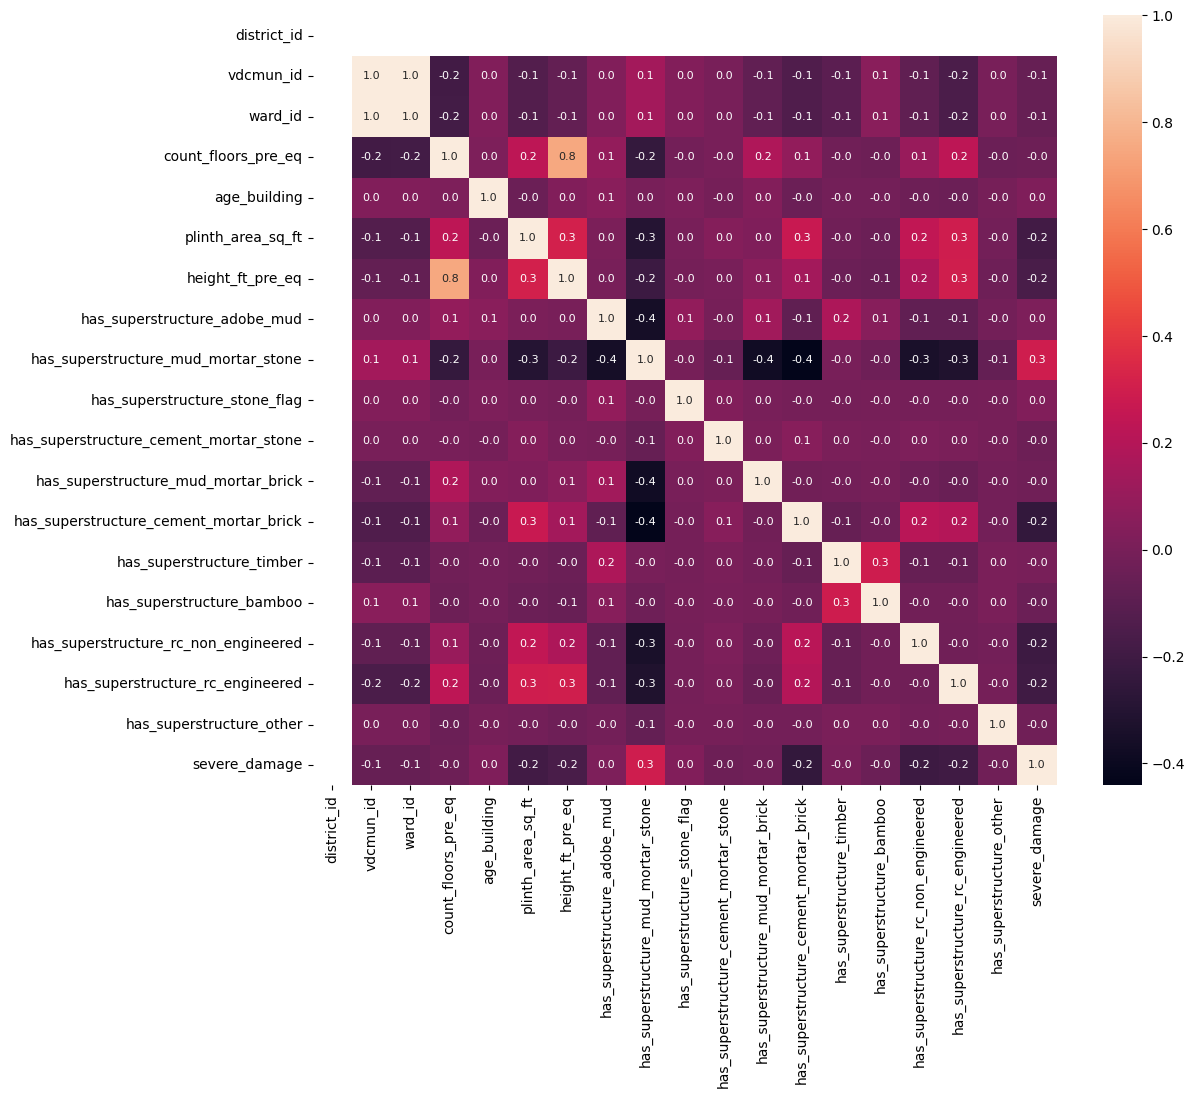

In [ ]:
# Create correlation matrix
correlation = df_processed.select_dtypes('number').corr()
# Plot heatmap of correlation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

We can see that there is a strong correlation between `count_floors_pre_eq` and `height_ft_pre_eq` (corr=0.8). To avoid multicollinearity, we will drop the feature with lower correlation (less predictive power) with the target `severe_damage`.


In [ ]:
# Get the correlation with severe_damage of the stronglyy correlated features
strongly_correlated_features = ['count_floors_pre_eq', 'height_ft_pre_eq']

# Calculate the correlations with 'severe_damage'
correlations_with_severe_damage = df_processed[strongly_correlated_features + ['severe_damage']].corr()['severe_damage'][:-1]

# Display the correlations
print(correlations_with_severe_damage)

count_floors_pre_eq   -0.039661
height_ft_pre_eq      -0.159843
Name: severe_damage, dtype: float64


Between `count_floors_pre_eq` and `height_ft_pre_eq`, `count_floors_pre_eq` has a lower predictive power (a weaker negative correlation), hence it will be dropped.

In [ ]:
df_processed.drop(columns='count_floors_pre_eq', inplace=True)
df_processed.shape

(98019, 25)

Let's see which types of land surfaces, foundations, roofs, and ground floors are associated with more or less severe building damage due to the earthquake.

In [ ]:
# create pivot table
foundation_pivot = pd.pivot_table(
    df_processed,index='land_surface_condition',
    values='severe_damage',
    aggfunc=np.mean
).sort_values(by='severe_damage')

# Plot pivot table
fig = px.line(
    foundation_pivot,
    x=foundation_pivot.index,
    y='severe_damage',
    title='Average Severe Damage by Land Surface Condition'
)

fig.show()

The plot shows that buildings on **flat land** experience the **least severe damage**, while those on **moderate and steep slopes** suffer **more severe damage**, suggesting that sloped terrain increases vulnerability during damaging events.

In [ ]:
# create pivot table
foundation_pivot = pd.pivot_table(
    df_processed,index='foundation_type',
    values='severe_damage',
    aggfunc=np.mean
).sort_values(by='severe_damage')

# Plot pivot table
fig = px.line(
    foundation_pivot,
    x=foundation_pivot.index,
    y='severe_damage',
    title='Average Severe Damage by Foundation Type'
)

fig.show()

The plot shows that buildings with **RC (Reinforced Concrete) foundations** experience the **least severe damage**, while those with **Mud mortar-Stone/Brick foundations** suffer the **most severe damage**, indicating a clear correlation between stronger foundation materials and lower damage severity.

In [ ]:
# create pivot table
foundation_pivot = pd.pivot_table(
    df_processed,index='roof_type',
    values='severe_damage',
    aggfunc=np.mean
).sort_values(by='severe_damage')

# Plot pivot table
fig = px.line(
    foundation_pivot,
    x=foundation_pivot.index,
    y='severe_damage',
    title='Average Severe Damage by Roof Type'
)

fig.show()



The plot shows that buildings with **RCC/RB/RBC (Reinforced Cement Concrete/Reinforced Brickwork/Reinforced Brick Concrete) roofs** experience the **least average severe damage**, while those with **Bamboo/Timber-Light roofs** experience the **most severe damage**, indicating that lighter, less durable roofing materials are associated with higher damage levels.

In [ ]:
# create pivot table
foundation_pivot = pd.pivot_table(
    df_processed,index='ground_floor_type',
    values='severe_damage',
    aggfunc=np.mean
).sort_values(by='severe_damage')

# Plot pivot table
fig = px.line(
    foundation_pivot,
    x=foundation_pivot.index,
    y='severe_damage',
    title='Average Severe Damage by Ground Floor Type'
)

fig.show()

This plot shows that buildings with **mud** or **brick/stone** ground floors experienced the **highest average severe damage**, while those with **RC (reinforced concrete)** ground floors had the lowest, indicating a clear correlation between stronger ground floor materials and lower damage severity.

## **Data Splitting**

To reduce the computational complexity of our model training, we will choose fewer features (9 in total) to act as the predictive variables for the model. These features are:  'age_building',
'plinth_area_sq_ft', 'height_ft_pre_eq', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'position', and 'plan_configuration'.

In [ ]:
# Set target and features DataFrames
target = "severe_damage"
X = df_processed[[ 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type',
       'position', 'plan_configuration']]
y = df_processed[target]
print(X.shape)
print(y.shape)

(98019, 9)
(98019,)


In [ ]:
# Split the data into training and testing sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (78415, 9)
y_train shape: (78415,)
X_test shape: (19604, 9)
y_test shape: (19604,)


In [ ]:
# Create a baseline accuracy for our model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5399


In [ ]:
# Check for high- and low-cardinality categorical features
df_processed.select_dtypes('object').nunique()

,0
land_surface_condition,3
foundation_type,5
roof_type,3
ground_floor_type,5
other_floor_type,4
position,4
plan_configuration,10


Our data has categorical features with high cardinality (more than two categories). To effectively and efficiently build our model, we are going to implement **ordinal encoding**, which simply replaces the categories in our categorical features with integers. This will help prevent the generation of multiple features during categorical encoding, thus reducing the complexity of the model training.

In [ ]:
# Create a pipeline with OrdinalEncoder and RandomForestClassifier
pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('random_forest', RandomForestClassifier(random_state=42))
])

In [ ]:
# Define the hyperparameter grid to search
param_grid = {
    'random_forest__n_estimators': range(100,1000,100),
    'random_forest__max_depth': range(10,50,10)
}

In [ ]:
# Create GridSearchCV object wih 3-fold cross validation to reduce tuning time
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 6. Get the best model
best_model = grid_search.best_estimator_

# Save the model
model_filename = 'best_random_forest_model_2.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to: {model_filename}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Hyperparameters: {'random_forest__max_depth': 10, 'random_forest__n_estimators': 400}
Best Score: 0.6685200703667098
Model saved to: best_random_forest_model_2.pkl


In [ ]:
# Load the cross validation results into a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.324813,0.247967,0.551065,0.177919,10,100,"{'random_forest__max_depth': 10, 'random_fores...",0.666361,0.666348,0.670403,0.667704,0.001909,9
1,11.413877,0.188744,0.626128,0.013027,10,200,"{'random_forest__max_depth': 10, 'random_fores...",0.667279,0.666424,0.670442,0.668048,0.001728,8
2,16.966513,0.365692,1.167996,0.289166,10,300,"{'random_forest__max_depth': 10, 'random_fores...",0.666781,0.666769,0.671283,0.668278,0.002125,7
3,21.259887,0.507127,1.483048,0.312538,10,400,"{'random_forest__max_depth': 10, 'random_fores...",0.667202,0.667075,0.671283,0.668520,0.001955,1
4,27.821916,0.088601,1.515616,0.025260,10,500,"{'random_forest__max_depth': 10, 'random_fores...",0.667394,0.666769,0.671168,0.668444,0.001944,4


In [ ]:
# Save cv_results to csv
cv_results.to_csv('cv_results(1).csv', index=False)

In [ ]:
cv_results = pd.read_csv('cv_results(1).csv')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.324813,0.247967,0.551065,0.177919,10,100,"{'random_forest__max_depth': 10, 'random_fores...",0.666361,0.666348,0.670403,0.667704,0.001909,9
1,11.413877,0.188744,0.626128,0.013027,10,200,"{'random_forest__max_depth': 10, 'random_fores...",0.667279,0.666424,0.670442,0.668048,0.001728,8
2,16.966513,0.365692,1.167996,0.289166,10,300,"{'random_forest__max_depth': 10, 'random_fores...",0.666781,0.666769,0.671283,0.668278,0.002125,7
3,21.259887,0.507127,1.483048,0.312538,10,400,"{'random_forest__max_depth': 10, 'random_fores...",0.667202,0.667075,0.671283,0.668520,0.001955,1
4,27.821916,0.088601,1.515616,0.025260,10,500,"{'random_forest__max_depth': 10, 'random_fores...",0.667394,0.666769,0.671168,0.668444,0.001944,4


In [ ]:
# Plot the tuning results of the hyper-parameters
fig = px.line(
    cv_results,
    x="param_random_forest__n_estimators",
    y="mean_test_score",
    color="param_random_forest__max_depth",
    title="Hyperparameter Tuning Results"
)
fig.show()

In [ ]:
# Pivot the data for the heatmap
heatmap_data = cv_results.pivot(
    index="param_random_forest__max_depth",
    columns="param_random_forest__n_estimators",
    values="mean_test_score"
)

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis',
    colorbar=dict(title="Mean Test Score")
))
fig.update_layout(
    title="Hyperparameter Tuning Heatmap",
    xaxis_title="n_estimators",
    yaxis_title="max_depth"
)
fig.show()

In [ ]:
# Plot the learning curve of the cross validation process

# Load the model
best_model = joblib.load('best_random_forest_model_2.pkl')

# Get the training and validation scores
train_sizes, train_scores, validation_scores = learning_curve(
    best_model, X_train, y_train, cv=3, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Create a DataFrame for plotting
learning_curve_df = pd.DataFrame({
    'Training Set Size': train_sizes,
    'Training Score': np.mean(train_scores, axis=1),
    'Validation Score': np.mean(validation_scores, axis=1)
})

# Melt the DataFrame to create a long-form structure for Plotly Express
learning_curve_df = learning_curve_df.melt(
    id_vars=['Training Set Size'],
    value_vars=['Training Score', 'Validation Score'],
    var_name='Score Type',
    value_name='Accuracy'
)

# Create the Plotly Express line plot
fig = px.line(
    learning_curve_df,
    x='Training Set Size',
    y='Accuracy',
    color='Score Type',
    title='Learning Curve of Cross Validation Process'
)
fig.show()

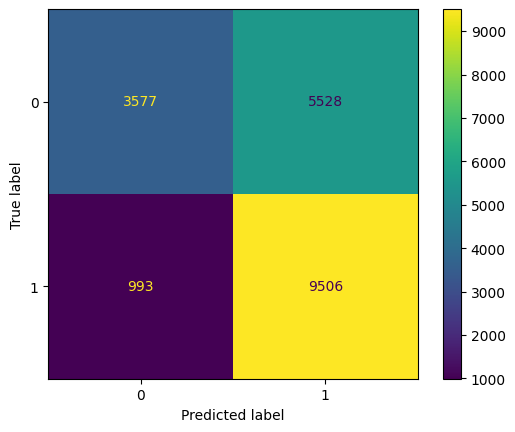

In [ ]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

---
Focusing on the performance of the model in predicting the severely damaged buildings (represented by 1), let's define the concepts of Precision, Recall, and F1-Score.

**1. Precision**: Precision answers the question: *Of all buildings the model predicted as "severely damaged", how many actually were?*

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{9506}{9506 + 5528} \approx 0.632
$$

About **63.2%** of the buildings the model said were severely damaged actually were.

N\B:
* TP = 9506: Correctly identified severely damaged buildings.
* TN = 3577: Correctly identified buildings that were not severely damaged.
* FP = 5528: Incorrectly identified non-damaged buildings as severely damaged.
* FN = 993: Failed to identify severely damaged buildings (missed them).

---

**2. Recall**: Recall answers the question: *Of all the buildings that were actually severely damaged, how many did the model correctly detect?*

$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{9506}{9506 + 993} \approx 0.906
$$

The model correctly identified **90.6%** of all severely damaged buildings.

---

**3. F1-Score**: F1-Score is the harmonic mean of precision and recall. It balances both metrics, especially useful when there's a trade-off between them.

$$
\text{F1-Score} = 2 \cdot \frac{(\text{Precision} \cdot \text{Recall})}{(\text{Precision} + \text{Recall})} \approx 2 \cdot \frac{(0.632 \cdot 0.906)}{(0.632 + 0.906)} \approx 0.745
$$

The F1-score of ~74.5% shows a balance between correctly identifying true positives and avoiding too many false positives.



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.39      0.52      9105
           1       0.63      0.91      0.74     10499

    accuracy                           0.67     19604
   macro avg       0.71      0.65      0.63     19604
weighted avg       0.70      0.67      0.64     19604



We can see that the precision, recall, and f1-score for the severely damaged class are just as we calculated. We can also notice that the scores for predicting the non-severely damaged class are lower. This is because of the class imbalance, which we are going to handle as we move further.

There is usually a trade-off between precision and recall, hence we will focus on the f1-score as it provides a balanced measure of both precision and recall, serving as the harmonic mean of these two metrics to offer a single value for overall model effectiveness.

In [ ]:
# Print the average f1-score of the model
 avg_f1 = f1_score(y_test, y_pred, average='macro')
 avg_f1

0.6338747225424517

## **Handling Class Imbalance**

Let's check if our `severe_damage` target has balanced classes.

In [ ]:
# Plot distribution of classes in severe_damage column
fig = px.histogram(
    df_processed,
    x='severe_damage',
    title="Distribution of Classes in 'severe_damage' column",
    histnorm='probability',
)

# Update x-axis type to 'category'
fig.update_xaxes(type='category')

fig.show()

We can see that about 55% of the buildings were not severely damaged while about 45% were severely damaged. This shows that our data has imbalanced classes.

In machine learning, imbalanced classes refer to classification problems where one class significantly outnumbers the other(s), leading to biased models that may perform well on the majority class while failing to detect the minority class (just as we saw for the non-severely damaged class). Models trained on imbalanced data may show misleadingly high accuracy but poor real-world performance. To address this, techniques such as resampling, using appropriate evaluation metrics (like precision, recall, or F1-score), adjusting class weights, or treating the task as anomaly detection are commonly employed to ensure balanced learning and meaningful predictions. In this project, we will compare the following techniques to handle the class imbalance in our dataset:

* **SMOTE (Synthetic Minority Oversampling Technique)**
* **Random Undersampling Technque (RUS)**

Note that only the training dataset (the testing dataset not included) will be balanced using the mentioned techniques above. This qill allow the model to learn from a balanced representation of classes while being evaluated on data that reflects the actual class distribution.


### **1. SMOTE (Synthetic Minority Oversampling Technique)**

SMOTE works by generating synthetic samples for the minority class. It does this by selecting a sample from the minority class and creating new, similar instances along the line segments joining it and its nearest minority class neighbors. This approach helps to balance the dataset and improves the model’s ability to learn meaningful patterns from both classes, thereby enhancing performance metrics such as recall and F1-score.

In [ ]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Identify categorical columns in X_train
categorical_cols = X_train.select_dtypes(include='object').columns

# Instantiate OrdinalEncoder
encoder = OrdinalEncoder(cols=categorical_cols)

# Fit and transform X_train
X_train_encoded = encoder.fit_transform(X_train)

# Apply SMOTE to the encoded data
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)
print(sorted(Counter(y_train_smote).items()))

[(0, 42334), (1, 42334)]


In [ ]:
print('Number of each class before smote is:',sorted(Counter(y_train).items()))
print('Number of each class after smote is:',sorted(Counter(y_train_smote).items()))

Number of each class before smote is: [(0, 36081), (1, 42334)]
Number of each class after smote is: [(0, 42334), (1, 42334)]


The minority class (0) has been oversampled to match the number of instances of the majority class (1). Let's fit the data to a standard RF model (without any hyper-paramter tuning) and see the results.

In [ ]:
# Fit the SMOTE-oversampled data to a standard RF model
smote_RF_model= RandomForestClassifier(random_state=42)
smote_RF_model.fit(X_train_smote,y_train_smote)

# Transform X_test using the same fitted encoder
X_test_encoded = encoder.transform(X_test)
# Make predictions for X_test
smote_pred = smote_RF_model.predict(X_test_encoded)

# Classification report of RFC with SMOTE on test Set
print(classification_report(y_test, smote_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60      9105
           1       0.66      0.68      0.67     10499

    accuracy                           0.64     19604
   macro avg       0.64      0.64      0.64     19604
weighted avg       0.64      0.64      0.64     19604



In [ ]:
# Print the average f1-score of the model
avg_f1 = f1_score(y_test, smote_pred, average='macro')
avg_f1

0.6379049011981903

After using SMOTE, we got a higher f1-score for the minority class (0) and a more balanced average f1-score for both classes. Let's fit the oversampled data to our previously saved model `best_model`, whose parameters we tuned.

In [ ]:
# Fit the SMOTE-oversampled data to the saved model 'best_model'
smote_RF_model = best_model.fit(X_train_smote,y_train_smote)

# Make predictions for X_test
smote_pred = smote_RF_model.predict(X_test_encoded)

# Classification report of RFC with SMOTE on test Set
print(classification_report(y_test, smote_pred))

              precision    recall  f1-score   support

           0       0.70      0.48      0.57      9105
           1       0.65      0.82      0.73     10499

    accuracy                           0.67     19604
   macro avg       0.68      0.65      0.65     19604
weighted avg       0.67      0.67      0.65     19604



In [ ]:
# Print the average f1-score of the model
avg_f1 = f1_score(y_test, smote_pred, average='macro')
avg_f1

0.6489716037073964

This gives us better results than using the standard RF model. Let's plot the confusion matrix.

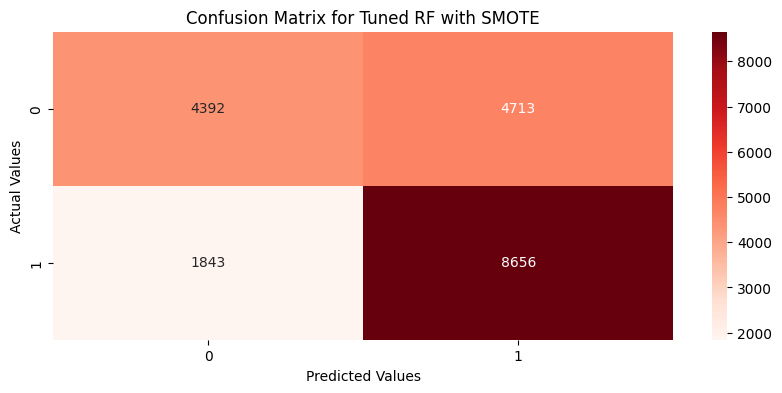

In [ ]:
cf_matrix=confusion_matrix(y_test, smote_pred)
plt.figure(figsize=(10,4))
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Tuned RF with SMOTE")
plt.show()

### **2. Random Undersampling Technique (RUS)**

Random undersampling is a technique used to address class imbalance in classification problems by reducing the number of samples in the majority class. Instead of adding new instances to the minority class (as in oversampling), this method randomly removes samples from the majority class to create a more balanced distribution between the two classes.

In [ ]:
# Instantiate Random Undersampler
rus = RandomUnderSampler(random_state=42)

# Apply Random Undersampling to the X_train
X_train_rus, y_train_rus = rus.fit_resample(X_train_encoded, y_train)
print(sorted(Counter(y_train_rus).items()))

[(0, 36081), (1, 36081)]


In [ ]:
print('Number of each class before RUS is:',sorted(Counter(y_train).items()))
print('Number of each class after RUS is:',sorted(Counter(y_train_rus).items()))

Number of each class before RUS is: [(0, 36081), (1, 42334)]
Number of each class after RUS is: [(0, 36081), (1, 36081)]


We can see that the majority class (1) has been undersampled to match the minority class (0).

In [ ]:
# Fit the undersampled data to a standard RF model
rus_RF_model= RandomForestClassifier(random_state=42)
rus_RF_model.fit(X_train_rus,y_train_rus)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on X_test
rus_pred = rus_RF_model.predict(X_test_encoded)

# Classification report of RFC with RUS on test Set
print(classification_report(y_test, rus_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      9105
           1       0.66      0.66      0.66     10499

    accuracy                           0.64     19604
   macro avg       0.64      0.64      0.64     19604
weighted avg       0.64      0.64      0.64     19604



In [ ]:
# Print the average f1-score of the model
avg_f1 = f1_score(y_test, rus_pred, average='macro')
avg_f1

0.6362587766610227

In [ ]:
# Fit the undersampled data to the 'best_model'
rus_RF_model = best_model.fit(X_train_rus,y_train_rus)

# Make predictions for X_test
rus_pred = rus_RF_model.predict(X_test_encoded)

# Classification report of RFC with RUS on test Set
print(classification_report(y_test, rus_pred))

              precision    recall  f1-score   support

           0       0.71      0.48      0.57      9105
           1       0.65      0.83      0.73     10499

    accuracy                           0.67     19604
   macro avg       0.68      0.65      0.65     19604
weighted avg       0.68      0.67      0.66     19604



In [ ]:
# Print the average f1-score of the model
avg_f1 = f1_score(y_test, rus_pred, average='macro')
avg_f1

0.6501144263688454

We have noticed an improvement in the average f1-score from 0.634 (without any resampling) to 0.650 (using the Random Undersampling Technique). This confirms that handling class imbalance provides a more balanced predictive power to our model.

## **Conclusion**

This project successfully demonstrated the application of machine learning to a critical real-world problem: predicting building damage from natural disasters. By meticulously preparing and analyzing structural data from the Nepal 2015 earthquake, a robust predictive model was developed. Crucially, the project highlighted and effectively addressed the challenge of class imbalance using techniques like SMOTE and Random Undersampling. This significantly improved the model's ability to accurately identify severely damaged buildings, which is vital for effective disaster preparedness and response.

The insights gained, particularly regarding the influence of structural characteristics like foundation and roof types on damage severity, provide valuable information for engineers and policymakers. The developed model serves as a practical tool that can inform pre-disaster mitigation efforts and post-disaster resource allocation, ultimately contributing to building more resilient communities in earthquake-prone regions.